In [49]:
# turn this into a .py file
!jupyter nbconvert --to script gemma_train_generate_ch03_v5.ipynb

[NbConvertApp] Converting notebook gemma_train_generate_ch03_v4.ipynb to script
[NbConvertApp] Writing 60069 bytes to gemma_train_generate_ch03_v4.py


# Training Gemma

### see: new .py file -> train_gemma.py

# TODO List

### 1. 
- gutenberg txt fine tuning
- epub-conversion fine-tuning
- alpaca/instruct fine tuning
- synthetic data fine tuning
  1. "Who's coming to the party"
- testing from-nothing training
- base model trimming, pruning
- classification head
- embedding head
- larger gemma-type models
- CPU-only version
- quantizing model after training
- dynamic-embeddings
- IoT Data
- Biological Signals & Behavior
  1. birdsong
  2. ants
  3. population stability

### 2. 
- full model training vs. lora-layer addition
- saving an reloading weights

### 3. 
- using the gemma 270m archetecture (or slight modification)
  1. adjust archetecture to compared across same synthetic data training
- making a public or crowd-sourced open MIT/APACHE2 weight set.
- STEM-Net Benchmarks: a range of synthetic training data types


# Based on rasbt, Sebastian Raschhka's (fabuloustastic) notebooks and book:

"
Supplementary code for the Build a Large Language Model From Scratch book by Sebastian Raschka

Code repository: https://github.com/rasbt/LLMs-from-scratch
"

# Gemma 3 270M From Scratch (A Standalone Notebook)

- This notebook is purposefully minimal and focuses on the code to re-implement Gemma 3 270M in pure PyTorch without relying on other external LLM libraries
- For more information, see the official [Gemma 3 270M model card](https://huggingface.co/google/gemma-3-270m)

- Below is a side-by-side comparison with Qwen3 0.6B as a reference model; if you are interested in the Qwen3 0.6B standalone notebook, you can find it [here](../11_qwen3)
<br>

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gemma3/gemma3-vs-qwen3.webp?1">
  
  
- About the code:
  - all code is my own code, mapping the Gemma 3 architecture onto the model code implemented in my [Build A Large Language Model (From Scratch)](http://mng.bz/orYv) book; the code is released under a permissive open-source Apache 2.0 license (see [LICENSE.txt](https://github.com/rasbt/LLMs-from-scratch/blob/main/LICENSE.txt))

In [25]:
# pip install -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch05/07_gpt_to_llama/requirements-extra.txt

In [26]:
from importlib.metadata import version

# modified
pkgs = [
"torch",  # to implement the model
"numpy",
"jupyter",  # to run this notebook
"huggingface-hub",  # to download pretrained weights
"tokenizers",  # to implement the tokenizer
"safetensors",
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

torch version: 2.8.0
numpy version: 2.3.2
jupyter version: 1.1.1
huggingface-hub version: 0.34.4
tokenizers version: 0.22.0
safetensors version: 0.6.2


- This notebook supports both the base model and the instructmodel; which model to use can be controlled via the following flag:

In [27]:
USE_INSTRUCT_MODEL = True

&nbsp;
# 1. Architecture code

In [28]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = nn.functional.gelu(x_fc1, approximate="tanh") * x_fc2
        return self.fc3(x)

In [29]:
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False):
        super().__init__()
        self.eps = eps
        # Gemma3 stores zero-centered weights and uses (1 + weight) during forward
        self.scale = nn.Parameter(torch.zeros(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        # Match HF Gemma3: compute norm in float32, then scale by (1 + w)
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim=True)
        x_norm = x_f * torch.rsqrt(var + self.eps)
        out = x_norm * (1.0 + self.scale.float())
         
        if self.shift is not None:
            out = out + self.shift.float()
         
        return out.to(input_dtype)

In [30]:
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))

    # Generate position indices
    positions = torch.arange(context_length, dtype=dtype)

    # Compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Split x into first half and second half
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    # Adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    # Apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    # It's ok to use lower-precision after applying cos and sin rotation
    return x_rotated.to(dtype=x.dtype)

In [31]:
class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False,
        query_pre_attn_scalar=None, dtype=None,
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

        if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
        else:
            self.scaling = (head_dim) ** -0.5


    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        # Apply RoPE
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K and V to match number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Scale queries
        queries = queries * self.scaling

        # Attention
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

In [32]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg, attn_type):
        super().__init__()
        self.attn_type = attn_type 

        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            head_dim=cfg["head_dim"],
            qk_norm=cfg["qk_norm"],
            query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
            dtype=cfg["dtype"],
        )
        self.ff = FeedForward(cfg)
        self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(
        self,
        x,
        mask_global,
        mask_local,
        cos_global,
        sin_global,
        cos_local,
        sin_local,
    ):
        # Shortcut connection for attention block
        shortcut = x
        x = self.input_layernorm(x)

        if self.attn_type == "sliding_attention":
            attn_mask = mask_local
            cos = cos_local
            sin = sin_local
        else:
            attn_mask = mask_global
            cos = cos_global
            sin = sin_global
        
        x_attn = self.att(x, attn_mask, cos, sin)
        x_attn = self.post_attention_layernorm(x_attn)
        x = shortcut + x_attn

        # Shortcut connection for feed forward block
        shortcut = x
        x_ffn = self.pre_feedforward_layernorm(x)
        x_ffn = self.ff(x_ffn)
        x_ffn = self.post_feedforward_layernorm(x_ffn)
        x = shortcut + x_ffn
        return x

In [33]:
class Gemma3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]
        
        # Main model parameters
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.blocks = nn.ModuleList([
            TransformerBlock(cfg, attn_type)for attn_type in cfg["layer_types"]
        ])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        self.cfg = cfg

        # Reusable utilities    
        cos_local, sin_local = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        cos_global, sin_global = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            dtype=torch.float32,
        )
        self.register_buffer("cos_local", cos_local, persistent=False)
        self.register_buffer("sin_local", sin_local, persistent=False)
        self.register_buffer("cos_global", cos_global, persistent=False)
        self.register_buffer("sin_global", sin_global, persistent=False)
    
    def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)
    
        # mask_global (future is masked: j > i)
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 1 1 1 1 1 1 1
        #     1:  0 0 1 1 1 1 1 1
        #     2:  0 0 0 1 1 1 1 1
        #     3:  0 0 0 0 1 1 1 1
        #     4:  0 0 0 0 0 1 1 1
        #     5:  0 0 0 0 0 0 1 1
        #     6:  0 0 0 0 0 0 0 1
        #     7:  0 0 0 0 0 0 0 0
        mask_global = torch.triu(ones, diagonal=1)
    
        # far_past (too far back is masked: i - j >= sliding_window)
        # where sliding_window = 4
        #     j:  0 1 2 3 4 5 6 7
        #  i
        #     0:  0 0 0 0 0 0 0 0
        #     1:  0 0 0 0 0 0 0 0
        #     2:  0 0 0 0 0 0 0 0
        #     3:  0 0 0 0 0 0 0 0
        #     4:  1 0 0 0 0 0 0 0
        #     5:  1 1 0 0 0 0 0 0
        #     6:  1 1 1 0 0 0 0 0
        #     7:  1 1 1 1 0 0 0 0
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T
    
        # Local (sliding_window) = future OR far-past
        # mask_local
        #     j:  0 1 2 3 4 5 6 7
        # i
        # 0:      0 1 1 1 1 1 1 1
        # 1:      0 0 1 1 1 1 1 1
        # 2:      0 0 0 1 1 1 1 1
        # 3:      0 0 0 0 1 1 1 1
        # 4:      1 0 0 0 0 1 1 1
        # 5:      1 1 0 0 0 0 1 1
        # 6:      1 1 1 0 0 0 0 1
        # 7:      1 1 1 1 0 0 0 0
        mask_local = mask_global | far_past
        return mask_global, mask_local

    def forward(self, input_ids):
        # Forward pass
        b, seq_len = input_ids.shape
        x = self.tok_emb(input_ids) * (self.cfg["emb_dim"] ** 0.5)
        mask_global, mask_local = self._create_masks(seq_len, x.device)

        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global,
                mask_local=mask_local,
                cos_global=self.cos_global,
                sin_global=self.sin_global,
                cos_local=self.cos_local,
                sin_local=self.sin_local,
            )

        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

&nbsp;
# 2. Initialize model

In [34]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 262_144,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

In [35]:
torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

In [36]:
model

Gemma3Model(
  (tok_emb): Embedding(262144, 640)
  (blocks): ModuleList(
    (0-17): 18 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=640, out_features=1024, bias=False)
        (W_key): Linear(in_features=640, out_features=256, bias=False)
        (W_value): Linear(in_features=640, out_features=256, bias=False)
        (out_proj): Linear(in_features=1024, out_features=640, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=640, out_features=2048, bias=False)
        (fc2): Linear(in_features=640, out_features=2048, bias=False)
        (fc3): Linear(in_features=2048, out_features=640, bias=False)
      )
      (input_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (out_head): Linear(in_features=640, out_features

- A quick check that the forward pass works before continuing:

In [37]:
model(torch.tensor([1, 2, 3]).unsqueeze(0))

tensor([[[ 0.7539,  0.1060,  0.4805,  ...,  0.9375,  0.4043, -0.2383],
         [-0.3418, -0.0576,  0.8984,  ..., -0.2432,  0.4629,  0.8242],
         [-0.2695, -0.3281,  0.4102,  ...,  0.8750, -0.9727,  0.9844]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [38]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 435,870,336

Total number of unique parameters: 268,098,176


In [39]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 3.37 GB
bfloat16: 1.69 GB


In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

&nbsp;
# 4. Load pretrained weights

In [41]:
def load_weights_into_gemma(model, param_config, params):

    def assign(left, right, tensor_name="unknown"):
        if left.shape != right.shape:
            raise ValueError(
                f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}"
            )
        return torch.nn.Parameter(right.clone().detach() if isinstance(right, torch.Tensor) else torch.tensor(right))

    # Embedding weights
    if "model.embed_tokens.weight" in params:
        model.tok_emb.weight = assign(
            model.tok_emb.weight,
            params["model.embed_tokens.weight"],
            "model.embed_tokens.weight",
        )

    # Iterate over transformer layers
    for l in range(param_config["n_layers"]):
        block = model.blocks[l]
        att = block.att
        # Attention projections
        att.W_query.weight = assign(
            att.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight",
        )
        att.W_key.weight = assign(
            att.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight",
        )
        att.W_value.weight = assign(
            att.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight",
        )
        att.out_proj.weight = assign(
            att.out_proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight",
        )
        # QK normalization weights
        att.q_norm.scale = assign(
            att.q_norm.scale,
            params[f"model.layers.{l}.self_attn.q_norm.weight"],
            f"model.layers.{l}.self_attn.q_norm.weight",
        )
        att.k_norm.scale = assign(
            att.k_norm.scale,
            params[f"model.layers.{l}.self_attn.k_norm.weight"],
            f"model.layers.{l}.self_attn.k_norm.weight",
        )
        # Feed forward weights
        block.ff.fc1.weight = assign(
            block.ff.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight",
        )
        block.ff.fc2.weight = assign(
            block.ff.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight",
        )
        block.ff.fc3.weight = assign(
            block.ff.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight",
        )
        # LayerNorm weights
        block.input_layernorm.scale = assign(
            block.input_layernorm.scale,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight",
        )
        block.post_attention_layernorm.scale = assign(
            block.post_attention_layernorm.scale,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight",
        )
        # Pre‑ and post‑feed forward norms
        pre_key = f"model.layers.{l}.pre_feedforward_layernorm.weight"
        post_key = f"model.layers.{l}.post_feedforward_layernorm.weight"
        if pre_key in params:
            block.pre_feedforward_layernorm.scale = assign(
                block.pre_feedforward_layernorm.scale,
                params[pre_key],
                pre_key,
            )
        if post_key in params:
            block.post_feedforward_layernorm.scale = assign(
                block.post_feedforward_layernorm.scale,
                params[post_key],
                post_key,
            )

    # Final LayerNorm
    if "model.norm.weight" in params:
        model.final_norm.scale = assign(
            model.final_norm.scale,
            params["model.norm.weight"],
            "model.norm.weight",
        )
    # Output head
    if "lm_head.weight" in params:
        model.out_head.weight = assign(
            model.out_head.weight,
            params["lm_head.weight"],
            "lm_head.weight",
        )
    elif "model.embed_tokens.weight" in params:
        # Weight tying: reuse the embedding weights
        model.out_head.weight = assign(
            model.out_head.weight,
            params["model.embed_tokens.weight"],
            "model.embed_tokens.weight",
        )

- Please note that Google requires that you accept the Gemma 3 licensing terms before you can download the files; to do this, you have to create a Hugging Face Hub account and visit the [google/gemma-3-270m](https://huggingface.co/google/gemma-3-270m) repository to accept the terms
- Next, you will need to create an access token; to generate an access token with READ permissions, click on the profile picture in the upper right and click on "Settings"


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/settings.webp?1" width="300px">

- Then, create and copy the access token so you can copy & paste it into the next code cell

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/access-token.webp?1" width="600px">

In [42]:
# Uncomment and run the following code if you are executing the notebook for the first time

#from huggingface_hub import login
#login()

In [43]:
import json
import os
from pathlib import Path
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download, snapshot_download

CHOOSE_MODEL = "270m"

if USE_INSTRUCT_MODEL:
    repo_id = f"google/gemma-3-{CHOOSE_MODEL}-it"
else:
    repo_id = f"google/gemma-3-{CHOOSE_MODEL}"


local_dir = Path(repo_id).parts[-1]

if CHOOSE_MODEL == "270m":
    weights_file = hf_hub_download(
        repo_id=repo_id,
        filename="model.safetensors",
        local_dir=local_dir,
    )
    weights_dict = load_file(weights_file)
else:
    repo_dir = snapshot_download(repo_id=repo_id, local_dir=local_dir)
    index_path = os.path.join(repo_dir, "model.safetensors.index.json")
    with open(index_path, "r") as f:
        index = json.load(f)

    weights_dict = {}
    for filename in set(index["weight_map"].values()):
        shard_path = os.path.join(repo_dir, filename)
        shard = load_file(shard_path)
        weights_dict.update(shard)

load_weights_into_gemma(model, GEMMA3_CONFIG_270M, weights_dict)
model.to(device)
del weights_dict

&nbsp;
# 4. Load tokenizer

In [45]:
from tokenizers import Tokenizer


class GemmaTokenizer:
    def __init__(self, tokenizer_file_path: str):
        tok_file = Path(tokenizer_file_path)
        self._tok = Tokenizer.from_file(str(tok_file))
        # Attempt to identify EOS and padding tokens
        eos_token = "<end_of_turn>"
        self.pad_token_id = eos_token
        self.eos_token_id = eos_token

    def encode(self, text: str) -> list[int]:
        return self._tok.encode(text).ids

    def decode(self, ids: list[int]) -> str:
        return self._tok.decode(ids, skip_special_tokens=False)


def apply_chat_template(user_text):
    return f"<start_of_turn>user\n{user_text}<end_of_turn>\n<start_of_turn>model\n"

In [46]:
tokenizer_file_path = os.path.join(local_dir, "tokenizer.json")
if not os.path.exists(tokenizer_file_path):
    try:
        tokenizer_file_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json", local_dir=local_dir)
    except Exception as e:
        print(f"Warning: failed to download tokenizer.json: {e}")
        tokenizer_file_path = "tokenizer.json"

tokenizer = GemmaTokenizer(tokenizer_file_path=tokenizer_file_path)

In [47]:
prompt = "Give me a short introduction to large language models."
prompt = apply_chat_template("Give me a short introduction to large language models.")


input_token_ids = tokenizer.encode(prompt)
text = tokenizer.decode(input_token_ids)
text

'<bos><start_of_turn>user\nGive me a short introduction to large language models.<end_of_turn>\n<start_of_turn>model\n'

&nbsp;
# 5. Generate text

In [28]:
# Optionally use torch.compile for an extra speed-up
# model = torch.compile(model)

In [29]:
def generate_text_basic_stream(model, token_ids, max_new_tokens, eos_token_id=None):

    model.eval()
    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(token_ids)[:, -1]
            next_token = torch.argmax(out, dim=-1, keepdim=True)

            if (eos_token_id is not None
                   and torch.all(next_token == eos_token_id)):
               break

            yield next_token
            
            token_ids = torch.cat([token_ids, next_token], dim=1)

In [30]:
input_token_ids_tensor = torch.tensor(input_token_ids, device=device).unsqueeze(0)


for token in generate_text_basic_stream(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=500,
    eos_token_id=tokenizer.encode("<end_of_turn>")[-1]
):
    token_id = token.squeeze(0).tolist()
    print(
        tokenizer.decode(token_id),
        end="",
        flush=True
    )

Large language models (LLMs) are sophisticated artificial intelligence systems that can understand, generate, and manipulate human language. They are trained on massive amounts of text data to learn patterns and relationships within language, enabling them to perform a wide range of tasks, from writing articles and answering questions to translating languages and summarizing information.


&nbsp;
# What's next?

- Check out the [README.md](./README.md), to use this model via the `llms_from_scratch` package
- For those interested in a comprehensive guide on building a large language model from scratch and gaining a deeper understanding of its mechanics, you might like my [Build a Large Language Model (From Scratch)](http://mng.bz/orYv)

<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>

"end of original code"

# Mod: Training Gemma

Points to Emphasize:

Architecture Differences:

RoPE vs learned positional embeddings
Sliding window attention
RMSNorm vs LayerNorm
Larger vocabulary impact


Memory Management:

Why we reduce context length
Gradient accumulation explanation
bfloat16 precision benefits


Tokenization Differences:

Larger vocabulary effects
Different special tokens
Chat template for instruct models


Training Adaptations:

No dropout in Gemma
Different learning rate
Gradient clipping importance

In [6]:
# !python3 -m pip install matplotlib

In [10]:
# !python3 -m pip install GPUtil

In [9]:
# ## Training Gemma 3 270M
# 
# This section demonstrates how to train/fine-tune the Gemma 3 270M model using the training infrastructure
# we've developed. We'll walk through data preparation, model initialization, and the training process.

# ### Setup and Environment Check

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
import urllib.request
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download
from tokenizers import Tokenizer
import time
import psutil
import GPUtil

In [11]:
# Check GPU availability and memory
def check_gpu_memory():
    if torch.cuda.is_available():
        gpu = GPUtil.getGPUs()[0]
        print(f"GPU: {gpu.name}")
        print(f"Total memory: {gpu.memoryTotal:.1f} MB")
        print(f"Free memory: {gpu.memoryFree:.1f} MB")
        print(f"Used memory: {gpu.memoryUsed:.1f} MB")
        
        # PyTorch's view
        device_id = torch.cuda.current_device()
        allocated = torch.cuda.memory_allocated(device_id) / 1024**3
        reserved = torch.cuda.memory_reserved(device_id) / 1024**3
        print(f"\nPyTorch allocated: {allocated:.2f} GB")
        print(f"PyTorch reserved: {reserved:.2f} GB")
    else:
        print("No GPU available. Training will be slow on CPU.")
        print(f"CPU cores: {psutil.cpu_count()}")
        print(f"RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")

check_gpu_memory()


GPU: NVIDIA RTX 3500 Ada Generation Laptop GPU
Total memory: 12282.0 MB
Free memory: 11992.0 MB
Used memory: 12.0 MB

PyTorch allocated: 0.00 GB
PyTorch reserved: 0.00 GB


In [12]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()  # Clear any cached memory
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"\nUsing device: {device}")


Using device: cuda


In [13]:

# We'll use Project Gutenberg texts for training. This provides more data than "The Verdict" 
# used in the GPT-2 example, which is necessary for the larger vocabulary of Gemma.

# Download multiple Gutenberg texts for more training data
def download_gutenberg_texts():
    """Download a collection of public domain texts for training"""
    
    texts = {
        # "shakespeare.txt": "https://www.gutenberg.org/files/100/100-0.txt",  # Complete Shakespeare
        "alice.txt": "https://www.gutenberg.org/files/11/11-0.txt",  # Alice in Wonderland
        # "pride_prejudice.txt": "https://www.gutenberg.org/files/1342/1342-0.txt",  # Pride and Prejudice
        # "frankenstein.txt": "https://www.gutenberg.org/files/84/84-0.txt",  # Frankenstein
    }
    
    combined_text = ""
    
    for filename, url in texts.items():
        file_path = f"data/{filename}"
        os.makedirs("data", exist_ok=True)
        
        if not os.path.exists(file_path):
            print(f"Downloading {filename}...")
            with urllib.request.urlopen(url) as response:
                text_data = response.read().decode('utf-8')
            with open(file_path, "w", encoding="utf-8") as file:
                file.write(text_data)
        else:
            print(f"Loading existing {filename}...")
            with open(file_path, "r", encoding="utf-8") as file:
                text_data = file.read()
        
        # Clean and combine texts
        # Remove Gutenberg headers/footers if present
        start_marker = "*** START OF"
        end_marker = "*** END OF"
        
        start_idx = text_data.find(start_marker)
        if start_idx != -1:
            start_idx = text_data.find("\n", start_idx) + 1
            text_data = text_data[start_idx:]
        
        end_idx = text_data.find(end_marker)
        if end_idx != -1:
            text_data = text_data[:end_idx]
        
        combined_text += text_data + "\n\n"
    
    return combined_text

# Load the training data
print("Loading training data...")
text_data = download_gutenberg_texts()

print(f"Total characters loaded: {len(text_data):,}")
print(f"First 200 characters:\n{text_data[:200]}")
print(f"\nLast 200 characters:\n{text_data[-200:]}")

Loading training data...
Total characters loaded: 144,604
First 200 characters:

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER II

Last 200 characters:
m of Wonderland of long ago: and how she
would feel with all their simple sorrows, and find a pleasure in all
their simple joys, remembering her own child-life, and the happy summer
days.

THE END






In [14]:
### Tokenizer Setup and Data Analysis
# 
# Gemma uses a much larger vocabulary (262k tokens) compared to GPT-2 (50k tokens).
# Let's set up the tokenizer and analyze our data.

# Download and setup Gemma tokenizer
USE_INSTRUCT_MODEL = False  # Set to True if you want to use the instruct variant

repo_id = "google/gemma-3-270m-it" if USE_INSTRUCT_MODEL else "google/gemma-3-270m"
local_dir = Path(repo_id).parts[-1]

# Download tokenizer
tokenizer_file_path = os.path.join(local_dir, "tokenizer.json")
if not os.path.exists(tokenizer_file_path):
    print("Downloading Gemma tokenizer...")
    # Note: You may need to authenticate with Hugging Face here
    # from huggingface_hub import login
    # login()
    tokenizer_file_path = hf_hub_download(
        repo_id=repo_id, 
        filename="tokenizer.json", 
        local_dir=local_dir
    )

# Initialize tokenizer
class GemmaTokenizer:
    def __init__(self, tokenizer_file_path: str):
        self._tok = Tokenizer.from_file(str(tokenizer_file_path))
        self.eos_token = "<end_of_turn>"
        self.pad_token = "<end_of_turn>"
        
    def encode(self, text: str) -> list[int]:
        return self._tok.encode(text).ids
    
    def decode(self, ids: list[int]) -> str:
        return self._tok.decode(ids, skip_special_tokens=False)

tokenizer = GemmaTokenizer(tokenizer_file_path=tokenizer_file_path)

# Analyze tokenization
print("Tokenizing data...")
start_time = time.time()
all_tokens = tokenizer.encode(text_data)
tokenization_time = time.time() - start_time

print(f"Tokenization completed in {tokenization_time:.2f} seconds")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Compression ratio: {len(text_data) / len(all_tokens):.2f} characters per token")
print(f"Unique tokens in data: {len(set(all_tokens)):,}")

# Sample tokenization
sample_text = "The quick brown fox jumps over the lazy dog."
sample_tokens = tokenizer.encode(sample_text)
print(f"\nSample text: '{sample_text}'")
print(f"Token count: {len(sample_tokens)}")
print(f"Token IDs: {sample_tokens[:10]}...")  # Show first 10
print(f"Decoded back: '{tokenizer.decode(sample_tokens)}'")

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Tokenizing data...
Tokenization completed in 0.05 seconds
Total tokens: 38,315
Compression ratio: 3.77 characters per token
Unique tokens in data: 3,833

Sample text: 'The quick brown fox jumps over the lazy dog.'
Token count: 11
Token IDs: [2, 818, 3823, 8864, 37423, 38167, 1024, 506, 31770, 4799]...
Decoded back: '<bos>The quick brown fox jumps over the lazy dog.'


In [15]:

# ### Model Configuration and Memory Planning
# 
# Let's configure the model for our available GPU memory (12-13GB target)

# Gemma 3 270M configuration
GEMMA3_CONFIG_270M = {
    "vocab_size": 262_144,
    "context_length": 512,  # Reduced for memory constraints (original: 32,768)
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
    "layer_types": [
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention",
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention",
        "sliding_attention", "sliding_attention", "sliding_attention",
        "sliding_attention", "sliding_attention", "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

# Training settings optimized for memory constraints
TRAINING_SETTINGS = {
    "use_pretrained": True,  # Start from pretrained weights
    "use_instruct": USE_INSTRUCT_MODEL,
    "context_length": 512,  # Adjust based on your GPU memory
    "batch_size": 1,
    "gradient_accumulation_steps": 4,  # Simulate batch_size=4
    "learning_rate": 5e-5,
    "num_epochs": 3,
    "weight_decay": 0.01,
    "warmup_steps": 100,
}

# Memory estimation
def estimate_memory_usage(config, settings):
    """Estimate GPU memory requirements"""
    # Model parameters
    total_params = (
        config["vocab_size"] * config["emb_dim"] +  # Token embeddings
        config["n_layers"] * (
            4 * config["emb_dim"]**2 +  # Attention weights (Q,K,V,O)
            3 * config["emb_dim"] * config["hidden_dim"]  # FFN weights
        ) +
        config["emb_dim"] * config["vocab_size"]  # Output layer
    )
    
    model_memory_gb = (total_params * 2) / (1024**3)  # 2 bytes for bfloat16
    
    # Optimizer states (Adam uses 2x model memory for momentum and variance)
    optimizer_memory_gb = model_memory_gb * 2
    
    # Activation memory (rough estimate)
    seq_len = settings["context_length"]
    batch_size = settings["batch_size"]
    activation_memory_gb = (
        batch_size * seq_len * config["emb_dim"] * config["n_layers"] * 4
    ) / (1024**3)
    
    total_memory_gb = model_memory_gb + optimizer_memory_gb + activation_memory_gb
    
    print(f"Memory Estimation:")
    print(f"  Model weights: {model_memory_gb:.2f} GB")
    print(f"  Optimizer states: {optimizer_memory_gb:.2f} GB")
    print(f"  Activations (approx): {activation_memory_gb:.2f} GB")
    print(f"  Total estimated: {total_memory_gb:.2f} GB")
    
    return total_memory_gb

estimated_memory = estimate_memory_usage(GEMMA3_CONFIG_270M, TRAINING_SETTINGS)

if estimated_memory > 12:
    print(f"\n⚠️ Warning: Estimated memory usage ({estimated_memory:.1f} GB) exceeds target (12 GB)")
    print("Consider reducing context_length or using gradient checkpointing")

Memory Estimation:
  Model weights: 0.81 GB
  Optimizer states: 1.62 GB
  Activations (approx): 0.02 GB
  Total estimated: 2.46 GB


In [16]:

# ### Data Validation for Training
# 
# Ensure we have enough data for our context windows

min_tokens_needed = TRAINING_SETTINGS["context_length"] * 10  # At least 10 sequences

if len(all_tokens) < min_tokens_needed:
    print(f"⚠️ Warning: You have {len(all_tokens):,} tokens, but {min_tokens_needed:,} is recommended")
    print(f"Consider adding more text data or reducing context_length")
else:
    print(f"✓ Sufficient tokens for training: {len(all_tokens):,}")
    
# Calculate train/val split
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_text = text_data[:split_idx]
val_text = text_data[split_idx:]

train_tokens = len(tokenizer.encode(train_text))
val_tokens = len(tokenizer.encode(val_text))

print(f"\nData split:")
print(f"  Training: {train_tokens:,} tokens ({train_ratio*100:.0f}%)")
print(f"  Validation: {val_tokens:,} tokens ({(1-train_ratio)*100:.0f}%)")

# Check if we have enough tokens for even one batch
contexts_in_train = train_tokens // TRAINING_SETTINGS["context_length"]
contexts_in_val = val_tokens // TRAINING_SETTINGS["context_length"]

print(f"\nPossible training sequences: {contexts_in_train:,}")
print(f"Possible validation sequences: {contexts_in_val:,}")

if contexts_in_train < 1 or contexts_in_val < 1:
    print("❌ Error: Not enough data for the specified context length!")
    print("Please reduce context_length or add more training data")

✓ Sufficient tokens for training: 38,315

Data split:
  Training: 34,493 tokens (90%)
  Validation: 3,824 tokens (10%)

Possible training sequences: 67
Possible validation sequences: 7


In [39]:

# ### Initialize Model
# 
# Now let's initialize the Gemma model and optionally load pretrained weights

print("Initializing Gemma 3 270M model...")

# Initialize model
model = Gemma3Model(GEMMA3_CONFIG_270M)

# Load pretrained weights if specified
if TRAINING_SETTINGS["use_pretrained"]:
    print("Loading pretrained weights from Hugging Face...")
    
    weights_file = hf_hub_download(
        repo_id=repo_id,
        filename="model.safetensors",
        local_dir=local_dir,
    )
    
    weights_dict = load_file(weights_file)
    load_weights_into_gemma(model, GEMMA3_CONFIG_270M, weights_dict)
    del weights_dict  # Free memory immediately
    
    print("✓ Pretrained weights loaded successfully")
else:
    print("Initializing with random weights (training from scratch)")

# Move model to device
model = model.to(device)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size (bfloat16): {total_params * 2 / 1e9:.2f} GB")

# Check GPU memory after model loading
if torch.cuda.is_available():
    torch.cuda.synchronize()
    allocated = torch.cuda.memory_allocated() / 1024**3
    print(f"  GPU memory allocated: {allocated:.2f} GB")

Initializing Gemma 3 270M model...
Loading pretrained weights from Hugging Face...


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

✓ Pretrained weights loaded successfully

Model Statistics:
  Total parameters: 435,870,336
  Trainable parameters: 435,870,336
  Model size (bfloat16): 0.87 GB
  GPU memory allocated: 1.87 GB


In [41]:

# ### Pre-training Evaluation
# ### Pre-training Evaluation
# 
# Let's see how the model performs before training

def generate_text_simple(model, tokenizer, prompt, max_new_tokens=50):
    """Simple generation for evaluation using the working Gemma generation code"""
    model.eval()
    
    # Encode prompt
    token_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor(token_ids).unsqueeze(0).to(device)
    
    # Get EOS token ID if it exists
    try:
        eos_token_id = tokenizer.encode("<end_of_turn>")[-1]
    except:
        eos_token_id = None
    
    generated_tokens = []
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Get logits for last token
            logits = model(input_ids)[:, -1, :]
            
            # Get next token (greedy)
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            
            # Check for EOS
            if eos_token_id is not None and torch.all(next_token == eos_token_id):
                break
            
            generated_tokens.append(next_token.item())
            
            # Append
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # Truncate if too long
            if input_ids.shape[1] > model.cfg["context_length"]:
                input_ids = input_ids[:, -model.cfg["context_length"]:]
    
    # Decode the full sequence
    full_sequence = token_ids + generated_tokens
    return tokenizer.decode(full_sequence)

# Alternative: Use the streaming version from the original notebook
def generate_text_stream(model, tokenizer, prompt, max_new_tokens=50):
    """Using the exact generation code from the working Gemma notebook"""
    model.eval()
    
    # Encode prompt
    token_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor(token_ids).unsqueeze(0).to(device)
    
    # Get EOS token ID
    try:
        eos_token_id = tokenizer.encode("<end_of_turn>")[-1]
    except:
        eos_token_id = None
    
    generated = token_ids.copy()  # Start with the prompt
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            out = model(input_ids)[:, -1]
            next_token = torch.argmax(out, dim=-1, keepdim=True)
            
            if eos_token_id is not None and torch.all(next_token == eos_token_id):
                break
            
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # Handle context overflow
            if input_ids.shape[1] > model.cfg["context_length"]:
                input_ids = input_ids[:, -model.cfg["context_length"]:]
    
    return tokenizer.decode(generated)

# Test generation before training
test_prompts = [
    "The meaning of life is",
    "Once upon a time",
    "In the beginning",
]


print("Model generation before training:\n")
for prompt in test_prompts:
    print(f"Prompt: '{prompt}'")
    output = generate_text_simple(model, tokenizer, prompt, max_new_tokens=30)
    print(f"Output: {output}\n")

Model generation before training:

Prompt: 'The meaning of life is'
Output: <bos>The meaning of life is not defined by the number of years you live, but by the quality of your life.

The quality of your life is the quality of your life

Prompt: 'Once upon a time'
Output: <bos>Once upon a time, there was a man named John. He was a man of many talents. He was a carpenter, a farmer, a farmer’s son,

Prompt: 'In the beginning'
Output: <bos>In the beginning of the 20th century, the United States was a country of immigrants. The first immigrants to come to the United States were from Europe.



In [42]:

# ### Create Data Loaders
# 
# Create PyTorch data loaders for training

from torch.utils.data import Dataset, DataLoader

class GemmaDataset(Dataset):
    """Dataset for Gemma training"""
    def __init__(self, text, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        
        # Tokenize all text
        self.tokens = tokenizer.encode(text)
        
        # Create sliding windows
        self.windows = []
        for i in range(0, len(self.tokens) - max_length, stride):
            self.windows.append(self.tokens[i:i + max_length + 1])  # +1 for target
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        input_ids = torch.tensor(window[:-1], dtype=torch.long)  # All but last
        target_ids = torch.tensor(window[1:], dtype=torch.long)   # All but first
        return input_ids, target_ids

# Create datasets
print("Creating data loaders...")

train_dataset = GemmaDataset(
    train_text, 
    tokenizer, 
    TRAINING_SETTINGS["context_length"],
    TRAINING_SETTINGS["context_length"]  # Non-overlapping windows
)

val_dataset = GemmaDataset(
    val_text,
    tokenizer,
    TRAINING_SETTINGS["context_length"],
    TRAINING_SETTINGS["context_length"]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAINING_SETTINGS["batch_size"],
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAINING_SETTINGS["batch_size"],
    shuffle=False,
    drop_last=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Verify data loader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"\nFirst batch shape - Inputs: {inputs.shape}, Targets: {targets.shape}")
    print(f"First few tokens: {inputs[0, :10].tolist()}")
    break

Creating data loaders...
Training batches: 67
Validation batches: 7

First batch shape - Inputs: torch.Size([1, 512]), Targets: torch.Size([1, 512])
First few tokens: [3324, 1116, 3774, 236764, 532, 116644, 586, 1176, 999, 24501]


In [43]:

# ### Calculate Initial Loss
# 
# Establish baseline performance metrics

def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculate loss for a single batch"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), 
        target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculate average loss over data loader"""
    model.eval()
    total_loss = 0.
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
    
    return total_loss / num_batches if num_batches > 0 else float("nan")

# Calculate initial losses
print("Calculating initial losses...")
train_loss_initial = calc_loss_loader(train_loader, model, device, num_batches=10)
val_loss_initial = calc_loss_loader(val_loader, model, device, num_batches=10)

print(f"Initial training loss: {train_loss_initial:.4f}")
print(f"Initial validation loss: {val_loss_initial:.4f}")
print(f"Initial perplexity: {torch.exp(torch.tensor(val_loss_initial)):.2f}")

Calculating initial losses...
Initial training loss: 3.8344
Initial validation loss: 3.6853
Initial perplexity: 39.86


In [44]:

# ### Training Loop
# 
# Now we'll train the model with gradient accumulation to work within memory constraints

import time
from tqdm import tqdm

def train_gemma(model, train_loader, val_loader, settings, device):
    """Training loop with gradient accumulation"""
    
    # Setup optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95)
    )
    
    # Learning rate scheduler (optional)
    total_steps = len(train_loader) * settings["num_epochs"] // settings["gradient_accumulation_steps"]
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=total_steps
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "learning_rates": []
    }
    
    # Training loop
    print(f"\nStarting training for {settings['num_epochs']} epochs...")
    print(f"Total optimization steps: {total_steps}")
    
    global_step = 0
    best_val_loss = float('inf')
    
    for epoch in range(settings["num_epochs"]):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{settings['num_epochs']}")
        
        optimizer.zero_grad()
        
        for batch_idx, (input_batch, target_batch) in enumerate(progress_bar):
            # Forward pass
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss = loss / settings["gradient_accumulation_steps"]
            
            # Backward pass
            loss.backward()
            
            epoch_loss += loss.item() * settings["gradient_accumulation_steps"]
            
            # Update weights after accumulation
            if (batch_idx + 1) % settings["gradient_accumulation_steps"] == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f'{loss.item() * settings["gradient_accumulation_steps"]:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })
        
        # Calculate epoch metrics
        avg_train_loss = epoch_loss / len(train_loader)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=20)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rates"].append(scheduler.get_last_lr()[0])
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Avg Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Perplexity: {torch.exp(torch.tensor(val_loss)):.2f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "gemma3_best.pth")
            print("  ✓ Saved best model")
        
        # Generate sample
        print(f"\n  Sample generation:")
        prompt = "Once upon a time"
        output = generate_text_simple(model, tokenizer, prompt, max_new_tokens=40)
        print(f"  '{output}'")
        
        # Check GPU memory
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**3
            print(f"\n  GPU memory: {allocated:.2f} GB")
    
    return history

# Run training
torch.manual_seed(42)  # For reproducibility
history = train_gemma(model, train_loader, val_loader, TRAINING_SETTINGS, device)


Starting training for 3 epochs...
Total optimization steps: 50


Epoch 1/3: 100%|██████| 67/67 [00:03<00:00, 16.79it/s, loss=2.6250, lr=3.84e-05]



Epoch 1 Summary:
  Avg Train Loss: 2.9142
  Val Loss: 2.8326
  Val Perplexity: 16.99
  ✓ Saved best model

  Sample generation:
  '<bos>Once upon a time, there was a little girl named Alice, who was a very curious little girl. She was very curious about the world, and she was very curious about the things that were happening in it. She'

  GPU memory: 4.34 GB


Epoch 2/3: 100%|██████| 67/67 [00:03<00:00, 17.42it/s, loss=2.6562, lr=1.44e-05]



Epoch 2 Summary:
  Avg Train Loss: 2.3032
  Val Loss: 2.8214
  Val Perplexity: 16.80
  ✓ Saved best model

  Sample generation:
  '<bos>Once upon a time, there was a little girl named Alice, who was a very curious creature. She was a very clever girl, and she was very fond of playing with the little mouse, the little rabbit, and'

  GPU memory: 4.34 GB


Epoch 3/3: 100%|██████| 67/67 [00:03<00:00, 17.37it/s, loss=1.7891, lr=1.97e-07]



Epoch 3 Summary:
  Avg Train Loss: 2.1531
  Val Loss: 2.8237
  Val Perplexity: 16.84

  Sample generation:
  '<bos>Once upon a time, there was a little girl named Alice, who was a very curious creature. She was a very clever girl, and she was very fond of playing with the little mouse, the little rabbit, and'

  GPU memory: 4.34 GB


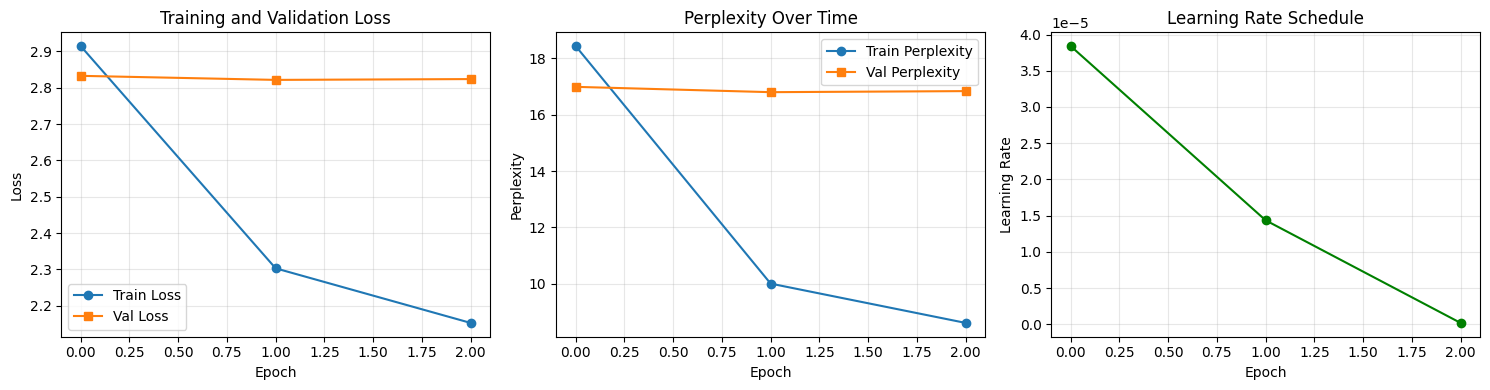


Training Complete!
Initial val loss: 3.6853 → Final val loss: 2.8237
Improvement: 23.4%


In [45]:

# ### Training Results Visualization
# 
# Plot the training curves to analyze performance

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0].plot(history["val_loss"], label="Val Loss", marker='s')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
train_perplexity = [torch.exp(torch.tensor(loss)).item() for loss in history["train_loss"]]
val_perplexity = [torch.exp(torch.tensor(loss)).item() for loss in history["val_loss"]]

axes[1].plot(train_perplexity, label="Train Perplexity", marker='o')
axes[1].plot(val_perplexity, label="Val Perplexity", marker='s')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Perplexity")
axes[1].set_title("Perplexity Over Time")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(history["learning_rates"], marker='o', color='green')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gemma_training_results.png", dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
print("\nTraining Complete!")
print(f"Initial val loss: {val_loss_initial:.4f} → Final val loss: {history['val_loss'][-1]:.4f}")
print(f"Improvement: {(val_loss_initial - history['val_loss'][-1]) / val_loss_initial * 100:.1f}%")

In [46]:

# ### Post-Training Evaluation
# 
# Compare model performance before and after training

# Load best model
model.load_state_dict(torch.load("gemma3_best.pth", map_location=device))
model.eval()

print("Model generation after training:\n")

# Test with same prompts as before
test_prompts = [
    "The meaning of life is",
    "Once upon a time",
    "In the beginning",
    "To be or not to be",
]

for prompt in test_prompts:
    print(f"Prompt: '{prompt}'")
    output = generate_text_simple(model, tokenizer, prompt, max_new_tokens=50)
    print(f"Output: {output}\n")
    print("-" * 80)

Model generation after training:

Prompt: 'The meaning of life is'
Output: <bos>The meaning of life is to live a life of love, and to love your enemies.

“Love your enemies, and you will win,” said the Lord.

“I’m not talking about the enemies,” said the King. “I’m talking about the

--------------------------------------------------------------------------------
Prompt: 'Once upon a time'
Output: <bos>Once upon a time, there was a little girl named Alice, who was a very curious creature. She was a very clever girl, and she was very fond of playing with the little mouse, the little rabbit, and the little frog.

One day, Alice was

--------------------------------------------------------------------------------
Prompt: 'In the beginning'
Output: <bos>In the beginning, I was a little nervous about the whole thing. I was a little nervous about the fact that I was going to be the first person to walk the length of the Earth, and I was afraid that I might get lost. I was afraid that

------

In [21]:
# ### Advanced Generation with Temperature and Top-k
# 
# Test more sophisticated generation strategies

def generate_advanced(model, tokenizer, prompt, max_new_tokens=50, temperature=0.8, top_k=50):
    """Advanced generation with temperature and top-k sampling"""
    model.eval()
    
    # Encode prompt
    token_ids = tokenizer.encode(prompt)
    input_ids = torch.tensor(token_ids).unsqueeze(0).to(device)
    
    # Get EOS token ID
    try:
        eos_token_id = tokenizer.encode("<end_of_turn>")[-1]
    except:
        eos_token_id = None
    
    generated = []
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Get logits
            logits = model(input_ids)[:, -1, :]
            
            # Apply temperature
            if temperature > 0:
                logits = logits / temperature
            
            # Top-k filtering
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')
            
            # Sample
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Check for EOS
            if eos_token_id is not None and torch.all(next_token == eos_token_id):
                break
            
            generated.append(next_token.item())
            
            # Append
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # Truncate if needed
            if input_ids.shape[1] > model.cfg["context_length"]:
                input_ids = input_ids[:, -model.cfg["context_length"]:]
    
    # Decode full sequence
    full_sequence = token_ids + generated
    return tokenizer.decode(full_sequence)

# Test different generation settings
generation_configs = [
    {"temperature": 0.5, "top_k": 10, "name": "Conservative"},
    {"temperature": 0.8, "top_k": 50, "name": "Balanced"},
    {"temperature": 1.2, "top_k": 100, "name": "Creative"},
]

prompt = "The future of artificial intelligence"

print("Testing different generation strategies:\n")
for config in generation_configs:
    print(f"{config['name']} (temp={config['temperature']}, top_k={config['top_k']}):")
    output = generate_advanced(
        model, tokenizer, prompt, 
        temperature=config['temperature'], 
        top_k=config['top_k'],
        max_new_tokens=50
    )
    print(f"{output}\n")
    print("-" * 80)

Testing different generation strategies:

Conservative (temp=0.5, top_k=10):


NameError: name 'tokenizer' is not defined

In [48]:
# for what?
def generate_and_print_sample(model, tokenizer, device, start_context):
    """Generate and print a sample during training"""
    model.eval()
    
    # Encode prompt
    token_ids = tokenizer.encode(start_context)
    input_ids = torch.tensor(token_ids).unsqueeze(0).to(device)
    
    # Get EOS token ID
    try:
        eos_token_id = tokenizer.encode("<end_of_turn>")[-1]
    except:
        eos_token_id = None
    
    generated = []
    
    with torch.no_grad():
        for _ in range(50):  # max_new_tokens
            logits = model(input_ids)[:, -1, :]
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            
            if eos_token_id is not None and torch.all(next_token == eos_token_id):
                break
            
            generated.append(next_token.item())
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # Handle context overflow
            if input_ids.shape[1] > model.cfg["context_length"]:
                input_ids = input_ids[:, -model.cfg["context_length"]:]
    
    # Decode and print
    full_sequence = token_ids + generated
    decoded_text = tokenizer.decode(full_sequence)
    print(decoded_text.replace("\n", " "))  # Compact print format
    
    model.train()

In [49]:

# ### Save Final Model and Training Summary
# 
# Save the trained model and create a summary report

# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'config': GEMMA3_CONFIG_270M,
    'training_settings': TRAINING_SETTINGS,
    'training_history': history,
    'final_metrics': {
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'best_val_loss': min(history['val_loss']),
        'total_epochs': TRAINING_SETTINGS['num_epochs']
    }
}, 'gemma3_trained_complete.pth')

print("Training Summary")
print("=" * 50)
print(f"Model: Gemma 3 270M")
print(f"Training data size: {len(all_tokens):,} tokens")
print(f"Context length: {TRAINING_SETTINGS['context_length']}")
print(f"Batch size: {TRAINING_SETTINGS['batch_size']} (effective: {TRAINING_SETTINGS['batch_size'] * TRAINING_SETTINGS['gradient_accumulation_steps']})")
print(f"Learning rate: {TRAINING_SETTINGS['learning_rate']}")
print(f"Epochs: {TRAINING_SETTINGS['num_epochs']}")
print(f"\nResults:")
print(f"  Initial loss: {val_loss_initial:.4f}")
print(f"  Final loss: {history['val_loss'][-1]:.4f}")
print(f"  Best loss: {min(history['val_loss']):.4f}")
print(f"  Improvement: {(1 - min(history['val_loss'])/val_loss_initial) * 100:.1f}%")

# Memory usage summary
if torch.cuda.is_available():
    max_allocated = torch.cuda.max_memory_allocated() / 1024**3
    print(f"\nPeak GPU memory usage: {max_allocated:.2f} GB")

Training Summary
Model: Gemma 3 270M
Training data size: 38,315 tokens
Context length: 512
Batch size: 1 (effective: 4)
Learning rate: 5e-05
Epochs: 3

Results:
  Initial loss: 3.6853
  Final loss: 2.8237
  Best loss: 2.8214
  Improvement: 23.4%

Peak GPU memory usage: 5.64 GB


In [50]:

# ### Next Steps and Recommendations
# 
# Based on the training results, here are some suggestions for further improvement:

print("Recommendations for Further Training:\n")

# Analyze if model is overfitting or underfitting
if len(history['val_loss']) > 1:
    if history['val_loss'][-1] > history['val_loss'][-2]:
        print("⚠️ Validation loss increased in last epoch - possible overfitting")
        print("   Consider: reducing learning rate, adding dropout, or early stopping")
    elif abs(history['train_loss'][-1] - history['val_loss'][-1]) > 0.5:
        print("⚠️ Large gap between train and val loss - likely overfitting")
        print("   Consider: more regularization, data augmentation, or smaller model")
    elif history['train_loss'][-1] > 3.0:
        print("⚠️ Training loss still high - possible underfitting")
        print("   Consider: longer training, higher learning rate, or more complex model")
    else:
        print("✓ Training appears stable and converged well")

print("\nPotential improvements:")
print("1. Data: Add more diverse texts from Project Gutenberg")
print("2. Context: Try longer sequences if memory allows (current: 512)")
print("3. Batch size: Use gradient accumulation to simulate larger batches")
print("4. Learning rate: Experiment with warmup and different schedules")
print("5. Fine-tuning: Try task-specific datasets for better performance")

# Provide code snippet for loading the model later
print("\n" + "="*50)
print("To load this model later, use:\n")
print("""
# Load the trained model
checkpoint = torch.load('gemma3_trained_complete.pth', map_location=device)
model = Gemma3Model(checkpoint['config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# View training history
history = checkpoint['training_history']
print(f"Best validation loss: {checkpoint['final_metrics']['best_val_loss']:.4f}")
""")

Recommendations for Further Training:

⚠️ Validation loss increased in last epoch - possible overfitting
   Consider: reducing learning rate, adding dropout, or early stopping

Potential improvements:
1. Data: Add more diverse texts from Project Gutenberg
2. Context: Try longer sequences if memory allows (current: 512)
3. Batch size: Use gradient accumulation to simulate larger batches
4. Learning rate: Experiment with warmup and different schedules
5. Fine-tuning: Try task-specific datasets for better performance

To load this model later, use:


# Load the trained model
checkpoint = torch.load('gemma3_trained_complete.pth', map_location=device)
model = Gemma3Model(checkpoint['config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# View training history
history = checkpoint['training_history']
print(f"Best validation loss: {checkpoint['final_metrics']['best_val_loss']:.4f}")



In [18]:
# Reload the complete model for continued training or inference
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# model.to(device);

In [19]:
# Reload the complete model for continued training or inference
import torch

# Load the checkpoint
checkpoint = torch.load('gemma3_trained_complete.pth', map_location=device)

# Recreate the model with the same configuration
model = Gemma3Model(checkpoint['config'])

# Load the state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move to device
model = model.to(device)



Model loaded successfully
Training epochs completed: 3
Best validation loss: 2.8214


In [ ]:
# If you want to continue training, set to train mode
# model.train()

# # Access training history if needed
# training_history = checkpoint['training_history']
# final_metrics = checkpoint['final_metrics']

# # Print out some information
# print("Model loaded successfully")
# print(f"Training epochs completed: {final_metrics['total_epochs']}")
# print(f"Best validation loss: {final_metrics['best_val_loss']:.4f}")




In [ ]:
# Or for inference
model.eval()

In [48]:
# Test different generation settings
generation_configs = [
    {"temperature": 0.5, "top_k": 10, "name": "Conservative"},
    {"temperature": 0.8, "top_k": 50, "name": "Balanced"},
    {"temperature": 1.2, "top_k": 100, "name": "Creative"},
]

prompt = "The future of artificial intelligence"

print("Testing different generation strategies:\n")
for config in generation_configs:
    print(f"{config['name']} (temp={config['temperature']}, top_k={config['top_k']}):")
    output = generate_advanced(
        model, tokenizer, prompt, 
        temperature=config['temperature'], 
        top_k=config['top_k'],
        max_new_tokens=50
    )
    print(f"{output}\n")
    print("-" * 80)

Testing different generation strategies:

Conservative (temp=0.5, top_k=10):
<bos>The future of artificial intelligence (AI) is poised to revolutionize many aspects of our lives, and it's clear that this technology will have a profound impact on the world.  While the potential benefits are immense, the development and deployment of AI also raise significant ethical and societal

--------------------------------------------------------------------------------
Balanced (temp=0.8, top_k=50):
<bos>The future of artificial intelligence (AI) is poised for profound and transformative changes across various sectors. While the potential benefits are undeniable, the rapid advancement of AI technologies presents significant challenges and ethical considerations that must be carefully addressed. This paper explores the multifaceted challenges and opportunities presented by AI

--------------------------------------------------------------------------------
Creative (temp=1.2, top_k=100):
<bos>The 